<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/bgRemoval/tests/MODNet_Image_Matting_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Removal - MODNet

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/pdf/2011.11961.pdf)          [![GitHub stars](https://img.shields.io/github/stars/ZHKKKe/MODNet?style=social)](https://github.com/ZHKKKe/MODNet)



## 1. linking nextcloud

Connecting to the external NextCloud drive 


In [ ]:
# we'll link the dataset from next-cloud
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py

from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

input_folder, output_folder = create_io(database=nextcloud,topic='bgRemoval',library='MODNet')

what's the username for nextcloud? colab
what's the password for user colab? ··········
0
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  
content of /etc/fstab: https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ /content/database davfs user,rw,auto 0 0


## 2. Clone the GIT repo and download the model

In [ ]:
output_folder

'/content/database/bgRemoval/MODNet'

In [ ]:
import os

# clone the repository
if not os.path.exists('/content/MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet /content/MODNet
%cd /content/MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

Cloning into '/content/MODNet'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 270 (delta 31), reused 30 (delta 11), pack-reused 206
Receiving objects: 100% (270/270), 60.77 MiB | 22.98 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/MODNet
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 257MB/s]


## 3. Inference

<p align="justify">Run the following command for alpha matte prediction:</p>

In [ ]:
!python -m demo.image_matting.colab.inference \
        --input-path {input_folder} \
        --output-path {output_folder} \
        --ckpt-path pretrained/modnet_photographic_portrait_matting.ckpt

Process image: LB_0001.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


## 4. Visualization

<p align="justify">Display the results (from left to right: image, foreground, and alpha matte):</p>

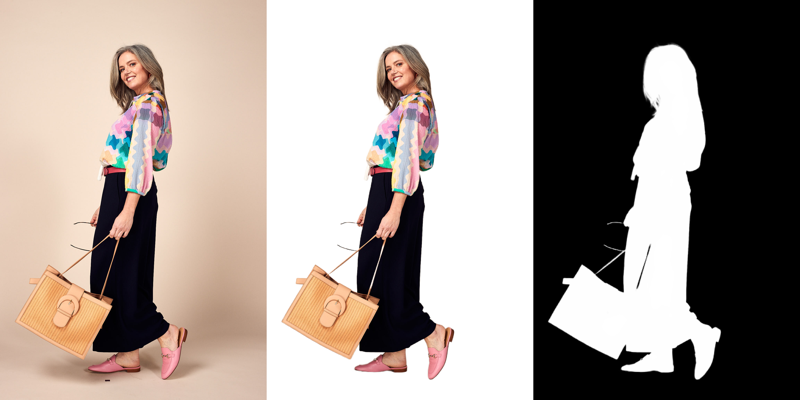

In [ ]:
import numpy as np
from PIL import Image
from os.path import isfile, join

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  display(combined_display(image, matte))
  print(image_name, '\n')

## 5. Download Results

<p align="justify">Download the Zip package of predicted alpha mattes:</p>

In [ ]:
from google.colab import files
zip_filename = 'matte.zip'
create_zip(zip_filename, output_folder)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done


In [ ]:
#TODO right now we're downloading the mask. Perhaps it is the easiest to download the mask, upscale it and then use it on the original image?